# Predict
Make sure to use theano backend for this
- Modify your ~/.keras/keras.json to change the backend to "theano"
- Set variables FN0, FN1, nb_train_samples, nb_val_samples and rnn_layers

In [2754]:
FN = 'predict'

if your GPU is busy you can use CPU for predictions

In [2755]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

In [2756]:
import theano
DEBUG = False
if DEBUG:
    import warnings
    warnings.filterwarnings('ignore','.*Warning, Cannot compute test value')
    warnings.filterwarnings('ignore','.*has no test value')
#     theano.config.optimizer='fast_compile'
#     theano.config.exception_verbosity='high'
    theano.config.optimizer='None'
    theano.config.compute_test_value = 'warn'

In [2757]:
import keras
keras.__version__

'2.1.6'

Generate headlines using the "simple" model from http://arxiv.org/pdf/1512.01712v1.pdf

Use indexing of tokens from [vocabulary-embedding](./vocabulary-embedding.ipynb) this does not clip the indexes of the words to `vocab_size`.

Use the index of outside words to replace them with several `oov` words (`oov` , `oov0`, `oov`...) that appear in the same description and headline. This will allow headline generator to replace the oov with the same word in the description

In [2758]:
FN0 = 'all-the-news-5000-vocab-embedding-smaller'

we will generate predictions using the model generated in this notebook

In [2759]:
FN1 = 'train-5000-2'

In [2760]:
nb_train_samples = 5000
nb_val_samples = 500

input data (`X`) is made from `maxlend` description words followed by `eos`
followed by headline words followed by `eos`
if description is shorter than `maxlend` it will be left padded with `empty`
if entire data is longer than `maxlen` it will be clipped and if it is shorter it will be padded.

labels (`Y`) are the headline words followed by `eos` and clipped or padded to `maxlenh`

In other words the input is made from a `maxlend` half in which the description is padded from the left
and a `maxlenh` half in which `eos` is followed by a headline followed by another `eos` if there is enough space.

The labels match only the second half and 
the first label matches the `eos` at the start of the second half (following the description in the first half)

the model parameters should be identical with what used in training but notice that `maxlend` is flexible

In [2761]:
maxlend = 25 # 0 - if we dont want to use description at all
maxlenh = 25
maxlen = maxlend + maxlenh
rnn_size = 512 * 2 if 'bilstm' in FN1 else 512
rnn_layers = 2  # match FN1
# rnn_layers = 3
batch_norm = False

the out of the first `activation_rnn_size` nodes from the top layer will be used for activation and the rest will be used to select predicted word

In [2762]:
activation_rnn_size = 40 if maxlend else 0

lambda_dim = 2*(rnn_size - activation_rnn_size)

In [2763]:
# training parameters
seed = 42
p_W, p_U, p_dense, weight_decay = 0, 0, 0, 0
optimizer = 'rmsprop'
batch_size=64

# read word embedding

In [2764]:
import pickle

with open('data/%s.pickle'%FN0, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [2765]:
nb_unknown_words = 10

In [2766]:
print('dimension of embedding space for words',embedding_size)
print('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print('total number of different words',len(idx2word), len(word2idx))
print('number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx))
print('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx))

dimension of embedding space for words 100
vocabulary size 17493 the last 10 words can be used as place holders for unknown/oov words
total number of different words 37514 37514
number of words outside vocabulary which we can substitue using glove similarity 8382
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) 11639


In [2767]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [2768]:
for i in range(vocab_size-nb_unknown_words, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [2769]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [2770]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [2771]:
def prt(label, x):
    print(label+':'),
    for w in x:
        print(idx2word[w]),
    print

# Model

In [2772]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.layers.core import Lambda
import keras.backend as K
K.backend()

'theano'

In [2773]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [2774]:
regularizer = l2(weight_decay) if weight_decay else None

## rnn model

start with a stacked LSTM, which is identical to the bottom of the model used in training

In [2775]:
rnn_model = Sequential()
if DEBUG:
    print('DEBUG')
    from keras.layers import InputLayer
    model_input = InputLayer(input_shape=(maxlen,))
    rnn_model.add(model_input)
    rnn_model.output.tag.test_value = np.random.randint(vocab_size,size=(batch_size,maxlen)).astype('float32')
rnn_model.add(Embedding(vocab_size, embedding_size,
                        input_length=maxlen,
#                         batch_input_shape=(batch_size,maxlen),
                        embeddings_regularizer=regularizer, weights=[embedding], mask_zero=True,
                        name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                kernel_regularizer=regularizer, recurrent_regularizer=regularizer,
                bias_regularizer=regularizer, dropout=p_W, recurrent_dropout=p_U,
                name='lstm_%d'%(i+1)
                  )
    rnn_model.add(lstm)
    rnn_model.add(Dropout(p_dense, name='dropout_%d'%(i+1)))

In [2776]:
if DEBUG:
    print(rnn_model.output.tag.test_value.shape)

### load

use the bottom weights from the trained model, and save the top weights for later

In [2777]:
rnn_model.load_weights('data/%s.hdf5'%FN1,by_name=True)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1749300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 512)           1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 512)           0         
Total params: 5,103,924
Trainable params: 5,103,924
Non-trainable params: 0
_________________________________________________________________


In [2778]:
print(rnn_model.layers[0].get_weights())

[array([[-0.01527273,  0.05486724,  0.02824154, ..., -0.00882072,
        -0.05777261, -0.04773293],
       [-0.05824773,  0.01578965, -0.01994223, ...,  0.04531222,
         0.04875275,  0.03054144],
       [-0.00444155, -0.0264328 ,  0.07507543, ..., -0.01620985,
         0.08389987,  0.0247697 ],
       ...,
       [-0.0364346 ,  0.03310443,  0.01621359, ...,  0.00080122,
        -0.05824996, -0.01143235],
       [ 0.01956535, -0.02479992,  0.00477357, ..., -0.00473689,
         0.02420149,  0.08577059],
       [-0.00399871, -0.05687615,  0.06186307, ...,  0.01086607,
        -0.00127954,  0.02430375]], dtype=float32)]


In [2780]:
import h5py
with h5py.File('data/%s.hdf5'%FN1, mode='r') as f:
    if 'layer_names' not in f.attrs and 'model_weights' in f:
        f = f['model_weights']
    weights = [np.copy(v) for v in f['time_distributed_2']['time_distributed_2'].values()]

In [2781]:
# kernel, bias
weights = np.array([weights[1], weights[0]])
list(map(lambda x: x.shape, weights))

[(944, 17493), (17493,)]

## headline model

A special layer that reduces the input just to its headline part (second half).
For each word in this part it concatenate the output of the previous layer (RNN)
with a weighted average of the outputs of the description part.
In this only the last `rnn_size - activation_rnn_size` are used from each output.
The first `activation_rnn_size` output is used to computer the weights for the averaging.

In [2782]:
def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=([2],[1]))
    if DEBUG:
        print(desc_avg_word.tag.test_value.shape)
        print(head_words.tag.test_value.shape)
    return K.concatenate((desc_avg_word, head_words))

In [2783]:
model = Sequential()
model.add(rnn_model)
model.summary()
if activation_rnn_size:
    model.add(Lambda(simple_context,
                     mask = lambda inputs, mask: mask[:,maxlend:],
                     output_shape = lambda input_shape: (input_shape[0], maxlenh, lambda_dim),
                     name='simplecontext_1'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_111 (Sequential)  (None, 50, 512)           5103924   
Total params: 5,103,924
Trainable params: 5,103,924
Non-trainable params: 0
_________________________________________________________________


In [2784]:
# we are not going to fit so we dont care about loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [2785]:
n = lambda_dim
n

944

perform the top dense of the trained model in numpy so we can play around with exactly how it works

In [2786]:
# out very own softmax
def output2probs(output):
    output = np.dot(output, weights[0]) + weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [2787]:
def output2probs1(output):
    output0 = np.dot(output[:n//2], weights[0][:n//2,:])
    output1 = np.dot(output[n//2:], weights[0][n//2:,:])
    output = output0 + output1 # + output0 * output1
    output += weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

# Test

In [2788]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [2789]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
print(samples)
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
print(data)

[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]]
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [2790]:
np.all(data[:,maxlend] == eos)

True

In [2791]:
data.shape,list(map(len, samples))

((1, 50), [26])

In [2792]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 25, 944)

# Sample generation

In [2793]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]

    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]

    return dead_samples, dead_scores

In [2794]:
# !pip install python-Levenshtein

In [2795]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([output2probs(prob[sample_length-maxlend-1]) for prob, sample_length in zip(probs, sample_lengths)])

In [2796]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < vocab_size-nb_unknown_words else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= vocab_size-nb_unknown_words])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [2797]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= vocab_size-nb_unknown_words:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [2798]:
import sys
import Levenshtein

def gensamples(X=None, X_test=None, Y_test=None, avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(X_test)-1)
        else:
            i = X
        print('HEAD %d:'%i,' '.join(idx2word[w] for w in Y_test[i]))
        print('DESC:',' '.join(idx2word[w] for w in X_test[i]))
        sys.stdout.flush()
        x = X_test[i]
    else:
        for w in X.split():
            w = w.rstrip('^')
            if not w in word2idx:
                word2idx[w] = word2idx.get(w, len(word2idx))

        x = [word2idx[w.rstrip('^')] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indicies
        if isinstance(avoid,str) or isinstance(avoid[0], int) or isinstance(avoid[0], np.int64):
            avoid = [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [vocab_fold([w if isinstance(w,int) or isinstance(w,np.int64) else word2idx[w] for w in a])
                 for a in avoid]

    print('HEADS:')
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, avoid_score=avoid_score,
                                   k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print(score, ' '.join(words))
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print(score, ' '.join(words))
        codes.append(code)
    return samples

In [2799]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [2800]:
# X = "* Billy Joel is looking for a buyer in Sagaponack^ . Now that he and wife Katie Lee Joel are splitting up , the singer is planning to sell the two oceanfront^ properties he bought for her in 2007 . The four-bedroom mansion ( No . 1 ) and smaller beach bungalow^ ( No . 2 ) will be listed with Corcoran 's Biana^ Stepanian^ for a combined $ 35 million . * Richard Bressler^ , the former CFO of Viacom and now a managing"
# Y = "Billy Joel Lists in Sagaponack^"

In [2801]:
# Read from eval pickle file
import pickle
import csv
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
rouge = Rouge()

with open('pickles/eval_100.pickle', 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

with open('5k-2-eval.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Reference', 'Description', 'Generated', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])

    for i in range(len(heads)):
        Y = heads[i][0]
        X = desc[i][0]

        print('HEAD: ', Y)
        try:
            samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)
            reference = [Y.split()]

            headline = samples[0][0][len(samples[0][1]):]

            candidate = [idx2word[w] for w in headline]
            candidate = candidate[:len(candidate)-1]
            head_str = ' '.join(idx2word[w] for w in headline[:len(headline)-1])

            # BLEU score
            bleu1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
            bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
            bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
            bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
            print('Cumulative 1-gram: %f' % bleu1)
            print('Cumulative 2-gram: %f' % bleu2)
            print('Cumulative 3-gram: %f' % bleu3)
            print('Cumulative 4-gram: %f' % bleu4)

            writer.writerow([Y, X, head_str, bleu1, bleu2, bleu3, bleu4])
        except:
            print('Failed to generate headlines.')
            writer.writerow([Y, X, 'N/A', 0, 0, 0, 0])


HEAD:  Patriots Day Is Best When It Digs Past the Heroism
HEADS:
2.654691219329834 
8.07150936126709 Times The
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  A Break in the Search for the Origin of Complex Life
HEADS:
5.642500400543213 New
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Obama s Ingenious Mention of Atticus Finch
HEADS:
5.055740594863892 The
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Donald Trump Meets and Assails the Press
HEADS:
2.623927593231201 
5.386254549026489 York
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Trump I Think Hacking Was Russian
HEADS:
2.5899767875671387 
7.812723159790039 The The
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.00000

/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


2.5625035762786865 
5.245250701904297 New
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  The Hermit Who Inadvertently Shaped Climate Change Science
HEADS:
2.929570436477661 
5.9648051261901855 York
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Trump Thanks L L
HEADS:
13.111138820648193 New The Times The
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  The Atlantic Daily Insight and Oversight
HEADS:
Failed to generate headlines.
HEAD:  The Atlantic Politics Policy Daily Survey Says Housing Policy
HEADS:
10.191288709640503 York The New
Cumulative 1-gram: 0.045112
Cumulative 2-gram: 0.078136
Cumulative 3-gram: 0.094181
Cumulative 4-gram: 0.102833
HEAD:  What the Investigation Into the Chicago Police Department Found
HEADS:
2.4993014335632324 
5.044368743896484 The
Cumulative 1-

194.189594745636 ronald email Governments adult stimulus fracture Castro View New Your Rain newest Briefing Repair Its NBC Not Fighting York of updated stray^ ISIS
203.13349437713623 Say Nunes Emotional uproar prospect Troubled adjacent York With News Times Year News Kelly <1>^ Get This amazing 11 Goes Support The House Board
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Why More Writers Should Talk About Money
HEADS:
202.80805826187134 Facing devout special strain warship Delay U Shoe Speech Gun Reports for Minister and Theaters Gold Soften Times The Gunman Rio Were Times Panama York
212.91595029830933 chocolate Crimes l Make pseudonym State Affleck Gawker the Day Nuclear in So Finds John Campaign Editor youngster <0>^ England Syria Pacific Dallas a mathematician
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
HEAD:  Americans Can Soon Buy Groceries 

In [2713]:
X = "This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     During his first press conference in several months,   Donald Trump vehemently denied Tuesday‚Äôs reports alleging that Russia had compromising information about him, calling it ‚Äúfake news. ‚Äù Trump also announced that his sons will take over the Trump Organization once he becomes president, a move ethics experts say doesn‚Äôt satisfy    concerns and Trump again refused to release his tax returns, saying ‚Äúthe only ones who care about my tax returns are reporters. ‚Äù Representative John Lewis and Senator Corey Booker testified against Senator Jeff Sessions during the second day of his Senate confirmation hearing to serve as U. S. attorney general. Rex Tillerson, Trump‚Äôs choice for secretary of state, was critical of Russia during his hearing, saying the country ‚Äúposes a danger‚Äù to the United States and transportation secretary nominee Elaine Chao said she hopes to ‚Äúunleash the potential‚Äù of private investment for federal infrastructure projects. Seek the Truth: ‚ÄúBuzzFeed‚Äôs decision to publish a dossier full of serious accusations against   Donald Trump on Tuesday raised serious questions,‚Äù writes David A. Graham, one of which concerns the journalism ethics of publishing a document full of unverified claims. A Plan in Jeopardy?: Republicans are facing a number of obstacles in their quest to repeal the Affordable Care Act, such as finding a suitable alternative that won‚Äôt leave millions of Americans without insurance. Still, the GOP is moving forward with its plan ‚Äî  for now. (Russell Berman) Divided We Fall: Trump‚Äôs critics will need to come together to minimize the damage they fear he will impose, argues Conor Friedersdorf. ‚ÄúYet large swaths of the right and left, including extremely thoughtful,   observers of the American scene, are behaving as if such cooperation is impossible. ‚Äù Why? Follow stories throughout the day with our Politics  Policy portal. More on Trump‚Äôs Business Plans: The   says he will turn all business operations over to his two sons once he assumes the presidency and won‚Äôt enter into any new deals with international partners. But ethics experts say Trump is still facing ‚Äúa constitutional crisis. ‚Äù (Maggie Haberman, Julie Hirschfeld Davis, and Eric Lipton, The New York Times) On the Defense: The cyber hack on the Democratic Party was instigated by an ‚Äúelite‚Äù unit of hackers ‚Äúlinked to the Russian military intelligence service, known as the GRU, and its targets span the globe and parallel the interests of the Russian state. ‚Äù The party never stood a chance against them. (Tim Johnson, McClatchy DC) A Look Inside: Marie Claire spoke with former ‚Äúskin chicks,‚Äù female members of the white supremacist movement. While the cause is   feelings of rage and a desire for community may be contributing to a growing number of women joining the movement. (Kate Storey) Thanks, Obama: Although reviews of his presidency will be mixed, writes Ezra Klein, Americans will miss several things about Barack Obama, namely ‚Äúhis decency. His   administration. The seriousness with which he approached his job. The faith he had in the American political system, and in Americans. ‚Äù (Vox) Solving a Mystery: Raheel Siddiqui, a Muslim Marine recruit, fell to his death during basic training in Parris Island, South Carolina, in March 2016. The Marine Corps ruled the death a suicide, but Siddiqui‚Äôs family thinks differently. Did a night of hazing go wrong? (Alex French, Esquire)   Before and After: Serving as commander in chief of the United States has taken a visible toll on President Obama. Click on these images to see how the president has aged over the past eight years. (Alan Taylor, The Atlantic) Senate confirmation hearings for   Trump‚Äôs Cabinet nominees began on Tuesday. What‚Äôs the one question you‚Äôd be afraid to answer honestly at your own confirmation hearing? Send your answers to hello@theatlantic. com, and our favorites will be featured in Friday‚Äôs Politics  Policy Daily.   by Elaine Godfrey (@elainejgodfrey) and Candice Norwood (@cjnorwoodwrites)""
Y = "The Atlantic  Politics & Policy Daily: Back-to-Back Sessions"

SyntaxError: EOL while scanning string literal (<ipython-input-2713-c246e9b1973f>, line 1)

In [ ]:
samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)

In [ ]:
X = "18 Cake GIFs That 'll Make You Moist"
Y = "Is it 350degF^ in here or is it just me ?"

In [1895]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
5.842418670654297 enraged playing playing


KeyError: 100100

In [1896]:
X = "President Barack Obama 's re-election campaign is fundraising off of comments on Obama 's birth certificate by Mitt Romney 's son Matt ."

In [1897]:
gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1, use_unk=True, short=False);

HEADS:
15.432276219129562 Report subsidiary for s May 13 in in May 13
20.45819543302059 Report subsidiary for s May 13 in in May 13 in Obama Agent
22.169368356466293 Report subsidiary for s May 13 in in May 13 State
23.624240252189338 Report subsidiary for s May 13 in in May 13 in Obama forty Report Breitbart
25.491706654429436 Report subsidiary for s May 13 in in May 13 in Obama eligible troubling stepped
27.66153925814433 Report subsidiary for s May 13 in in May 13 in Obama forty Report retake memoir memoir Breitbart
28.18587867100723 Report subsidiary for s May 13 in in May 13 in Obama eligible troubling stepped Breitbart
29.74173215031624 Report subsidiary for s May 13 in in May 13 in Obama forty Report retake memoir memoir
32.93222215771675 Report subsidiary for s May 13 in in May 13 in Obama forty Report retake memoir memoir Down
39.950773272787046 Report subsidiary for s May 13 in in May 13 in Obama forty Report retake memoir memoir Down athlete Breitbart


In [1898]:
X = "What have you been listening to this year ? If you want to find out using cold , hard evidence , then Spotify 's new Year in Music tool will tell you ."
Y = "Spotify Will Make You Smarter for Your App"

In [1899]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1)

HEADS:
21.190365344285965 Donald Trump s election to first state state


In [1900]:
headline = samples[0][0][len(samples[0][1]):]

In [1901]:
' '.join(idx2word[w] for w in headline)

'Donald Trump s election to first state state ~'

In [1902]:
avoid = headline

In [1903]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
15.060724568367004 Donald Trump rent behalf illinois presidential process


In [1904]:
avoid = samples[0][0][len(samples[0][1]):]

In [1905]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
16.590157836675644 Donald Trump rent North finance presidential election


In [1906]:
len(samples)

20

# Weights

In [1907]:
def wsimple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    assert mask.ndim == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    return activation_weights


class WSimpleContext(Lambda):
    def __init__(self):
        super(WSimpleContext, self).__init__(wsimple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = lambda_dim
        return (nb_samples, maxlenh, n)

In [1908]:
wmodel = Sequential()
wmodel.add(rnn_model)

In [1909]:
wmodel.add(Lambda(wsimple_context,
                 mask = lambda inputs, mask: mask[:,maxlend:],
                 output_shape = lambda input_shape: (input_shape[0], maxlenh, maxlend)))

In [1910]:
wmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)

## test

In [1911]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [1912]:
# X = "Representatives of the groups depicted in The Revenant^ spoke with BuzzFeed News about the actor 's Golden Globes speech calling on listeners to `` protect ... indigenous lands . ''"
# Y = "Native American Groups Officially Respond To Leonardo DiCaprio 's Call To Action"
X = "Ivanka Trump, special assistant to the president, told Fox News on Monday: ‚ÄúI try to stay out of politics. ‚Äù Trump was speaking to Fox  Friends, the morning show which this weekend broadcast an interview with Donald Trump and first lady Melania Trump. ‚ÄúI try to stay out of politics,‚Äù Ivanka Trump said in answer to a question about her father‚Äôs use of Twitter to bypass most normal channels of presidential communication. ‚ÄúHis political instincts are phenomenal. He did something that no one could have imagined he‚Äôd be able to accomplish.  ‚ÄúI feel blessed just being part of the ride from day one and before. But he did something pretty remarkable. But I don‚Äôt profess to be a political savant. ‚Äù Donald Trump won the 2016 election in the electoral college, after a campaign marked by bitter partisan rancour and interference by Russian actors working, according to a Washington Post report last week, at the direct instruction of Vladimir Putin to help Trump beat Hillary Clinton. Clinton won the popular vote by more than 2. 5 million ballots. Ivanka Trump became a trusted lieutenant to her father, delivering a   convention speech in Cleveland in July and moving to Washington in January with her husband, Jared Kushner, who is one of the president‚Äôs closest advisers. Her White House position is unpaid. Though Trump claims to ‚Äústay out of politics‚Äù she has been a familiar surrogate for her father in the media and on the world stage. Earlier in June, she told Fox  Friends: ‚ÄúWe‚Äôre really focused on why the American people elected Donald Trump as their president and implementing that plan. ‚Äù Amidst congressional and FBI investigations into links between Trump aides and Russia and the reported investigation of her father for possible obstruction of justice related to those probes, she said then: ‚ÄúIt is hard, and there‚Äôs a level of viciousness that I was not expecting. I was not expecting the intensity of this experience, but this isn‚Äôt supposed to be easy. ‚Äù Asked in the interview broadcast on Monday if she ever disagreed with her father  ‚Äî   who has, for example, pursued policies on climate change, pulling out of the Paris agreement, that might be thought anathema to a registered New York Democrat, which she until recently was  ‚Äî   the first daughter said: ‚ÄúSo naturally, there are areas where there is disagreement. ‚Äù Climate change, with women‚Äôs rights, is part of Ivanka Trump‚Äôs White House brief. ‚ÄúWe‚Äôre two different human beings,‚Äù she continued. ‚ÄúI think it‚Äôs normal to not have 100% aligned viewpoints on every issue. I don‚Äôt think anyone operates like that with a parent, or within the context of an administration. ‚ÄúAnd I think that all different viewpoints being at the table is a positive thing. And I think one of the things that, in this country we don‚Äôt have enough of, is dialogue. ‚Äù "
Y = "Ivanka Trump says ‚I try to stay out of politics‚ despite assisting at White House"

In [1927]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:


ValueError: shapes (944,) and (25,25) not aligned: 944 (dim 0) != 25 (dim 0)

In [1914]:
sample = samples[0][0]

In [1915]:
' '.join([idx2word[w] for w in sample])

'<0>^ she has been a familiar surrogate for her father in the media and on the world <1>^ Earlier in <2>^ she told Fox <3>^ ~ How the staunch for the doj gonna breast ~'

In [1916]:
data = sequence.pad_sequences([sample], maxlen=maxlen, value=empty, padding='post', truncating='post')
data.shape

(1, 50)

In [1917]:
weights = wmodel.predict(data, verbose=0, batch_size=1)
weights.shape

(1, 25, 25)

In [1918]:
startd = np.where(data[0,:] != empty)[0][0]
try:
    lenh = np.where(data[0,maxlend+1:] == eos)[0][0]
except:
    print('No EOS in data[0,maxlend+1:], using data[0,maxlend+1:].shape[0] instead')
    lenh = data[0, maxlend+1:].shape[0]
startd, lenh

(0, 8)

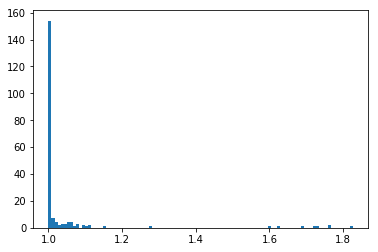

In [1919]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.array(weights[0,:lenh,startd:].flatten()+1), bins=100);

In [1920]:
import numpy as np
from IPython.core.display import display, HTML

def heat(sample,weights,dark=0.3):
    weights = (weights - weights.min())/(weights.max() - weights.min() + 1e-4)
    html = ''
    fmt = ' <span style="background-color: #{0:x}{0:x}ff">{1}</span>'
    for t,w in zip(sample,weights):
        c = int(256*((1.-dark)*(1.-w)+dark))
        html += fmt.format(c,idx2word[t])
    display(HTML(html))

In [1921]:
heat(sample, weights[0,-1])

In [1922]:
import pandas as pd
import seaborn as sns

In [1923]:
columns = [idx2word[data[0,i]] for i in range(startd,maxlend)]
rows = [idx2word[data[0,i]] for i in range(maxlend+1,maxlend+lenh+1)]

In [1924]:
df = pd.DataFrame(weights[0,:lenh,startd:],columns=columns,index=rows)

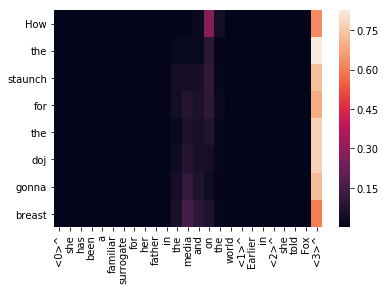

In [1925]:
sns.heatmap(df);